# Create Graph-based Structure

In [1]:
from lionagi.core import System, Instruction

system = System(
    "You are asked to perform as a calculator. Return only a numeric value, i.e. int or float, no text."
)

instruct1 = Instruction(
    instruction={
        "sum the absolute values": "provided with 2 numbers, return the sum of their absolute values. i.e. |x|+|y|",
    }
)

instruct2 = Instruction(
    instruction={
        "diff the absolute values": "provided with 2 numbers, return the difference of absolute values. i.e. |x|-|y|",
    }
)

instruct3 = Instruction(
    instruction={
        "if previous response is positive": "times 2. i.e. *2",  # case 0
        "else": "plus 2. i.e. +2",  # case 1
    }
)

In [2]:
from lionagi.core import Structure

struct = Structure()
struct.add_node(system)
struct.add_node(instruct1)
struct.add_node(instruct2)
struct.add_node(instruct3)

### Create Relationship Conditions

Conditions help filter the path to be executed.
It has to be an implemented subclass of Condition class.

There are two functions in Condition class:

```python
def __init__(self, source_type)
```

`source_type` can only be "structure" or "executable"

```python
@abstractmethod
def __call__(self, source)
```

All information in the structure and executable object is available for checking. 
`__call__` is expected to return a bool. If True, the path is selected.

If the `source_type` is "structure", the `source` is expected to be the structure object in the agent when checking the condition. 

If the `source_type` is "executable", the `source` is expected to be the executable object in the agent when checking the condition.

In [3]:
from lionagi.core import Condition


class CaseCondition(Condition):
    def __init__(self, case):
        super().__init__("executable")
        self.case = case

    def __call__(self, executable):
        case = executable.context["case"]
        return case == self.case


cond0 = CaseCondition(case=0)
cond1 = CaseCondition(case=1)

### Build Relationships with Conditions

In the example, if `case` is 0, execute `instruct1`, or if `case` is 1, execute `instruct2`.

Then, execute `instruct3`.

In [4]:
struct.add_relationship(system, instruct1, condition=cond0)
struct.add_relationship(system, instruct2, condition=cond1)
struct.add_relationship(instruct1, instruct3)
struct.add_relationship(instruct2, instruct3)

In [5]:
# %pip install networkx

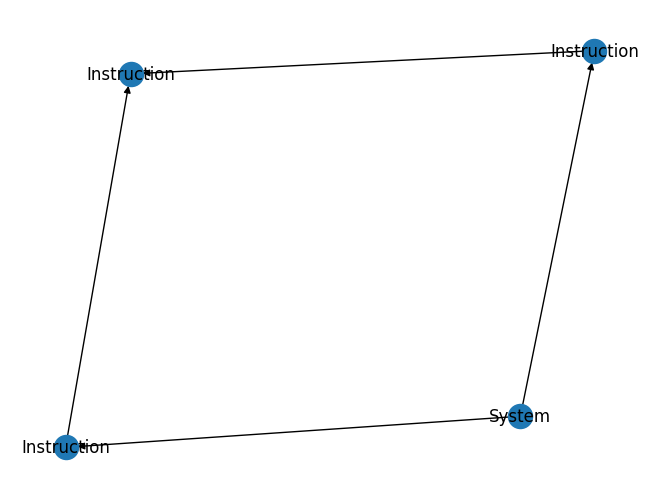

In [6]:
import networkx as nx

g = struct.graph.to_networkx()
labels = nx.get_node_attributes(g, "class_name")
nx.draw(g, labels=labels)

currently we only support at most one executable path after filtering.

In [7]:
from lionagi.core import ExecutableBranch, BaseAgent


# output_parser_func parameter: agent self
def output_parser(agent):
    return agent.executable.responses


executable = ExecutableBranch(
    verbose=False
)  # with verbose=False, the intermediate steps will not be printed

calc = BaseAgent(
    structure=struct, executable_obj=executable, output_parser=output_parser
)

In [8]:
result = await calc.execute(context={"x": -6, "y": 0, "case": 0})

In [9]:
calc.executable.branch.messages

,node_id,timestamp,role,sender,recipient,content
0,0cb16a5cbfe2b673519d8fda59d3d504,2024_03_22T15_00_18_081195+00_00,system,system,assistant,"{""system_info"": ""You are asked to perform as a..."
1,ceda8825058efe446c3eeedd4ef342fb,2024_03_22T15_00_18_081229+00_00,user,user,assistant,"{""instruction"": {""sum the absolute values"": ""p..."
2,34929b94b0e2b2191fd6666a6ae3e1cd,2024_03_22T15_00_20_291491+00_00,assistant,assistant,user,"{""response"": ""6""}"
3,35bdb21c06130aa90efde79800c0ba71,2024_03_22T15_00_18_081271+00_00,user,user,assistant,"{""instruction"": {""if previous response is posi..."
4,b0cadca930b58607c95cb3d865f4314a,2024_03_22T15_00_23_085179+00_00,assistant,assistant,user,"{""response"": ""12""}"
